In [1]:
# Configs
dataset_dir = r'C:\Users\fardin\Projects\EnhanceSEO\datasets\MaliciousURL1\malicious_phish.csv'

In [2]:
import torch
torch.__version__

'2.3.1+cu118'

In [19]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import BertTokenizer
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, TweetTokenizer
import time
import matplotlib.pyplot as plt
import random
from torch_scatter import scatter_max
from torch_scatter import scatter_mean
from torch_scatter import scatter_sum
from torch_scatter import scatter_std
import torchmetrics
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.flop_counter import FlopCounterMode

In [4]:
name = "microsoft/llmlingua-2-bert-base-multilingual-cased-meetingbank"
bert_tokenizer = BertTokenizer.from_pretrained(name)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024
device

device(type='cuda')

In [6]:
pd.read_csv(dataset_dir).head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [7]:
df = pd.read_csv(dataset_dir)
df.columns=['Address', 'Topic']
df.dropna(inplace=True)
class_list = df.Topic.unique()
class_id = {t:i for i, t in enumerate(class_list)}
id_class = {i:t for i, t in enumerate(class_list)}

In [8]:
chars = set([c for a in df.Address.values for c in ' '.join(bert_tokenizer.tokenize(a))])
vocab_dict = {c:i for i, c in enumerate(chars)}

In [9]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, num_classes, dictionary, tokenizer, doc_token_length=256, doc_char_length=1024) -> None:
        super().__init__()
        self.doc_char_length = doc_char_length
        self.doc_teken_length = doc_token_length
        
        
        y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        
        self.dictionary = dictionary
        self.dict_keys = list(dictionary.keys())
        self.vocab_size = len(self.dictionary)
        self.tokenizer = tokenizer
        
        self.X = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        # self.token_lengths = torch.zeros((len(X), self.doc_teken_length), dtype=torch.int)
        self.token_indices = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        
        for i, doc in enumerate(X):
            tokens = self.tokenizer(doc)
            tokens.append(self.dict_keys[-1])
            doc = ' '.join(tokens)
            
            indices = torch.from_numpy(np.array([self.dictionary[t] for t in doc if t in self.dictionary], dtype=np.longlong))
            char_pad_size = max(self.doc_char_length - len(indices), 0)
            
            self.X[i] = torch.nn.functional.pad(indices[:self.doc_char_length], (0,char_pad_size))
            
            token_lengths = torch.from_numpy(np.array([len(t) for t in tokens], dtype=np.longlong))+1
            token_lengths[-1] -= 1
            token_indices = torch.repeat_interleave(torch.arange(len(token_lengths), dtype=torch.long), token_lengths)
            token_indices = torch.nn.functional.pad(token_indices[:self.doc_char_length], (0,char_pad_size), value=len(token_lengths)-1)
            self.token_indices[i] = token_indices
        
        
    def __getitem__(self, index):
        return self.X[index], self.y[index], self.token_indices[index]
        
    def __len__(self):
        return len(self.y)
        

In [10]:
class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, batch_size, max_char_count, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, kernel_size=[5, 5, 3, 3], seed=-1, *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.max_char_count = max_char_count
        if seed>-1:
            torch.manual_seed(seed)
        
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        # nn.init.normal_(self.embedding.weight)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=kernel_size[0], padding=kernel_size[0]//2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size[1], padding=kernel_size[1]//2)
        
        # self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=kernel_size[2], padding=kernel_size[2]//2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size[3], padding=kernel_size[3]//2)
        
        self.globalpool = nn.AdaptiveMaxPool1d(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * hidden_dim, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
    
    def forward(self, x, token_counts):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        # x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x1 = scatter_max(x,token_counts, dim=1)[0]
        x2 = scatter_mean(x,token_counts, dim=1)
        # x2 = scatter_sum(x,token_counts, dim=1)
        # x2 = scatter_std(x,token_counts, dim=1)
        x = torch.cat([x1, x2], dim=2)
        # x = F.layer_norm(x, (x.shape[1], x.shape[2]))
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = self.globalpool(x)
        x = F.elu_(self.fc1(x.view(x.shape[0], -1)))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [11]:

class ClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(ClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters("model", logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, token_count, *args, **kwargs):
        return self.model(x, token_count)

    # def on_train_epoch_start(self) -> None:
    #     param_groups = next(iter(self.optimizer.param_groups))
    #     if "lr" in param_groups and param_groups["lr"] is not None:
    #         current_learning_rate = float(param_groups["lr"])
    #         self.log(
    #             "lr",
    #             current_learning_rate,
    #             batch_size=self.batch_size,
    #             on_epoch=True,
    #             on_step=False,
    #         )

    def training_step(self, batch, *args, **kwargs):
        X, y, token_count = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X, token_count)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y, token_count = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X, token_count)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True
        )
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [12]:
lr= 0.00344
output_size = 128
hidden_dim = 128
embedding_dim = 128
label_size = 1

In [13]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=True)
train_dataset = CharacterandTokenLevelCustomDataset(df_train.Address.values, df_train.Topic.values, len(class_id), vocab_dict, bert_tokenizer.tokenize, doc_token_length=64, doc_char_length=256)
test_dataset = CharacterandTokenLevelCustomDataset(df_test.Address.values, df_test.Topic.values, len(class_id), vocab_dict, bert_tokenizer.tokenize, doc_token_length=64, doc_char_length=256)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [14]:
seed = 911
# for i in range(5):
callbacks = [
    # EarlyStopping(monitor='val_loss',mode='min',patience=25),
    # CustomModelCheckpoint(dirpath=r'models\malicious_urls_model', filename=f'malicious_urls_model_', every_n_epochs=3, mode='min', monitor='val_loss_epoch', save_on_train_epoch_end=True),
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
    ]

classifier_torch_model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, max_char_count=256, dropout=0.2, num_out_features=len(class_id), kernel_size=[5, 5, 5, 3], seed=seed).to(device)
optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=0.000015)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240],gamma=0.5)
loss_func = torch.nn.BCEWithLogitsLoss()
classfier_lightning_model = ClassifierLightningModel(classifier_torch_model, 
                                                    num_classes=len(class_id),
                                            learning_rate=lr,
                                            batch_size=batch_size,
                                            optimizer=optimizer,
                                            loss_func=loss_func,
                                            lr_scheduler=lr_scheduler,
                                            user_lr_scheduler=True
                                            ).to(device)

from lightning.pytorch.loggers import CSVLogger
import lightning as L

trainer = L.Trainer(
            callbacks=callbacks,
            max_epochs=250,
            accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
            logger=CSVLogger(save_dir='logs/', name='log2')
        )

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 7.447319739059891e-06
Restoring states from the checkpoint path at c:\Users\fardin\Projects\EnhanceSEO\.lr_find_295ebe16-9739-44e6-8077-0e353f432cad.ckpt
Restored all states from the checkpoint at c:\Users\fardin\Projects\EnhanceSEO\.lr_find_295ebe16-9739-44e6-8077-0e353f432cad.ckpt
C:\Users\fardin\AppData\Local\Temp\ipykernel_24732\1989554445.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


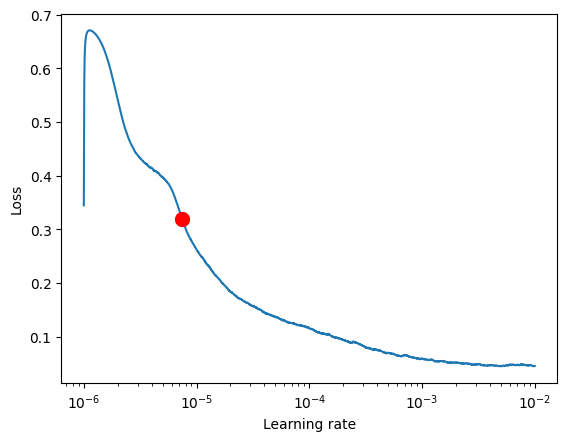

In [15]:
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
tuner_result = tuner.lr_find(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader, min_lr=1e-6, max_lr=0.01, num_training=5000)
fig = tuner_result.plot(suggest=True)
fig.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/5000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Learning rate set to 1.8569491014904616e-06
Restoring states from the checkpoint path at c:\Users\fardin\Projects\EnhanceSEO\.lr_find_c6d47e16-62d1-4977-ad97-7f7881c5d074.ckpt
Restored all states from the checkpoint at c:\Users\fardin\Projects\EnhanceSEO\.lr_find_c6d47e16-62d1-4977-ad97-7f7881c5d074.ckpt
C:\Users\fardin\AppData\Local\Temp\ipykernel_19656\1989554445.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


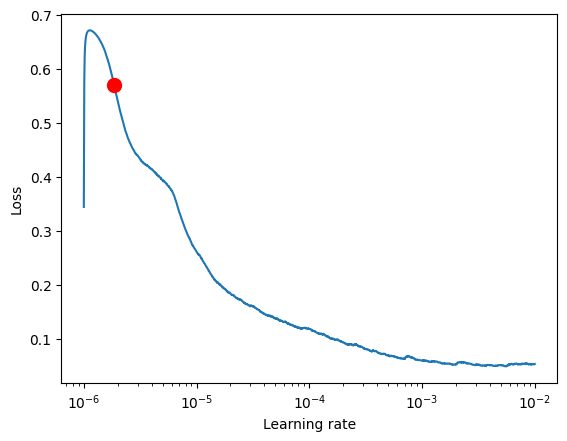

In [37]:
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
tuner_result = tuner.lr_find(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader, min_lr=1e-6, max_lr=0.01, num_training=5000)
fig = tuner_result.plot(suggest=True)
fig.show()

In [32]:
X, y, tc = next(iter(test_dataloader))
flopt_counter = FlopCounterMode(classfier_lightning_model.model)
with flopt_counter:
    classfier_lightning_model.model(X.to(device), tc.to(device))

In [16]:
trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNN_for_Text       | 933 K 
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
933 K     Trainable params
0         Non-trainable params
933 K     Total params
3.732     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


In [16]:
max_epochs = 205
trainer.fit_loop.max_epochs = max_epochs
trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory logs/log2\version_34\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNN_for_Text       | 241 K 
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
241 K     Trainable params
0         Non-trainable params
241 K     Total params
0.965     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [17]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torchmetrics.classification import ConfusionMatrix
def calculate_metrics(cl_model):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y, tc in tqdm(test_dataloader):
        X = X.to(device)
        tc = tc.to(device)
        with torch.no_grad():
            y_p = cl_model(X, tc)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [18]:
classfier_lightning_model.model = classfier_lightning_model.model.eval()
classfier_lightning_model = classfier_lightning_model.eval()
calculate_metrics(classfier_lightning_model)

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:02<00:00, 21.91it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9658    0.9531    0.9594      9423
           1     0.9908    0.9945    0.9927     42410
           2     0.9961    0.9993    0.9977      9521
           3     0.9929    0.9728    0.9827      3158

    accuracy                         0.9881     64512
   macro avg     0.9864    0.9799    0.9831     64512
weighted avg     0.9881    0.9881    0.9881     64512

confusion matrix:
 tensor([[ 8981,   387,    35,    20],
        [  232, 42178,     0,     0],
        [    5,     0,  9514,     2],
        [   81,     3,     2,  3072]])


In [20]:
p = 0.9864
r = 0.9799
(2*p*r)/(p+r)

0.9831392564715457